In [1]:
__author__ = 'Adam Scott <ascott@noao.edu>' # single string; emails in <>
__version__ = '20190103' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['ls_dr5']  # datasets used in this notebook; for available datasets, see cell "Available datasets in Data Lab" further below
__keywords__ = ['tutorial','query'], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/noaodatalab/notebooks_private/blob/master/internal/keywords.txt 

# CStore Performance Vs. Row Store
*Adam Scott & NOAO Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Query against Rowstore](#rstore)
* [Query against CStore](#cstore)
* [Graph of results](#graph)
* [When should I use CStore tables in Data Lab?](#when)

<a class="anchor" id="goals"></a>
# Goals
* Learn the difference between column store (cstore) and row store database tables
* Understand the circumstances when you might want to use cstore tables

# Summary

At Data Lab, we ran performance tests of various scenarios against many open-source DBMSs.  The cstore_fdw (for columnar store, foreign data wrapper), proved very fast for some applications.  Below we compare the run time between both storage formats.  (For more on cstore see https://github.com/citusdata/cstore_fdw)

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Basic Imports

In [2]:
# 3rd party
import matplotlib.pyplot as plt
%matplotlib inline

# Datalab
from dl import queryClient as qc

<a class="anchor" id="rstore"></a>
# Query against Rowstore

In [ ]:
%%time
query = """SELECT min(flux_g), max(flux_g), avg(flux_g),
                  min(flux_r), max(flux_r), avg(flux_r),
                  min(flux_z), max(flux_z), avg(flux_z)
           FROM ls_dr5.tractor
           WHERE psfsize_r > 0.6635 and psfsize_r < 1.327"""

# Send the query to the Queryclient in SQL, with a comma-separated-value (csv) output
response = qc.query(sql=query, fmt='csv')

In this run, it took **5min 22s** to execute the query against the normal rowstore table in Postgres.  Since `psfsize_r` is not indexed (only bold columns listed here are indexed: http://datalab.noao.edu/query.php?name=ls_dr5.tractor), the database has to read through every row in `ls_dr5.tractor` to find all rows satisfying the WHERE clause.

Compare this to the next run.

<a class="anchor" id="cstore"></a>
# Query Against CStore

In [ ]:
%%time
query = """SELECT min(flux_g), max(flux_g), avg(flux_g),
                  min(flux_r), max(flux_r), avg(flux_r),
                  min(flux_z), max(flux_z), avg(flux_z)
           FROM ls_dr5.tractor_cs
           WHERE psfsize_r > 0.6635 and psfsize_r < 1.327"""

# Send the query to the Queryclient in SQL, with a comma-separated-value (csv) output
response = qc.query(sql=query, fmt='csv')

This time, we queried against a cstore table (denoted by the `_cs` in the table name in the query above), and it took significantly less time at **3min 44s**.  Since cstore tables store the min/max values of each stripe, they have an inherent index **on every column** that requires litte extra space to store on disk.

<a class="anchor" id="graph"></a>
# Graph of results

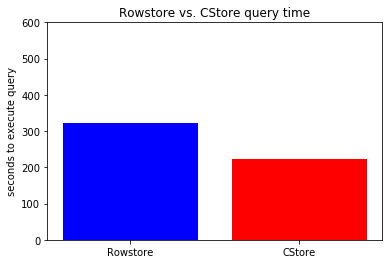

In [5]:
x = [1,2]
y = [322,224]
ax = plt.subplot()
pr, pc = plt.bar(x,y)
pr.set_facecolor('b')
pc.set_facecolor('r')
ax.set_xticks(x)
ax.set_xticklabels(['Rowstore','CStore'])
ax.set_ylim([0,600])
ax.set_ylabel('seconds to execute query')
ax.set_title('Rowstore vs. CStore query time')

<a class="anchor" id="when"></a>
# When should I use CStore tables in Data Lab?
We recommend running your query against a cstore table when your query's WHERE clause is against unindexed columns.

~~~~
SELECT <...>
FROM <...>_cs
WHERE unindexed_column <...>
~~~~

If some columns in the WHERE clause are indexed and others are not, there is not a universal recommendation.  A useful rule-of-thumb is when the number of rows to sample is > ~100,000 *after* applying the conditions of the indexed columns, you might try a cstore table to see if performance improves.
